[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/intel-analytics/BigDL/blob/main/python/chronos/colab-notebook/howto/how_to_train_forecaster_on_one_node.ipynb)

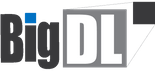

# Train forcaster on single node

## Introduction

In Chronos, Forecaster (`bigdl.chronos.forecaster.Forecaster`) is the forecasting abstraction. It hides the complex logic of model's creation, training, scaling to cluster,  tuning, optimization and inferencing while expose some APIs for users (e.g. `fit` in this guide) to control.

In this guidance, **we demonstrate how to train forecasters on one node**. In the training process, forecaster will learn the pattern (like the period, scale...) in history data. Although Chronos supports training on a cluster, it's highly recommeneded to try one node first before allocating a cluster to make life easier.

We will take `TCNForecaster` and nyc_taxi dataset as an exmaple in this guide.

## Setup

Before we begin, we need to install chronos if it isn’t already available, we choose to use pytorch as deep learning backend.

In [ ]:
!pip install --pre --upgrade bigdl-chronos[pytorch]
!pip uninstall -y torchtext # uninstall torchtext to avoid version conflict
exit()

## Data preparation

First, we load the nyc taxi dataset.

In [ ]:
from bigdl.chronos.data.repo_dataset import get_public_dataset
from sklearn.preprocessing import StandardScaler

tsdata_train, tsdata_val, _ = get_public_dataset(name='nyc_taxi')

stand = StandardScaler()
for tsdata in [tsdata_train, tsdata_val]:
    tsdata.impute()\
          .scale(stand, fit=tsdata is tsdata_train)

Forecaster supports learning history data in many formats, including:

1. `bigdl.chronos.data.TSDataset` (**recommended**)
2. pytorch dataloader
3. tensorflow dataset
4. numpy ndarray

It's always recommended to use `TSDataset` direcetly when possible, while many other formats are supported if users want to customize their own data processing and feature engineering procedure.

In [ ]:
# comment this line if you want to try other formats
train_data = tsdata_train

# uncomment this line to change `train_data` as pytorch dataloader
# train_data = tsdata_train.to_torch_data_loader(lookback=48, horizon=1)

# uncomment this line to change `train_data` as numpy ndarray
# train_data = tsdata_train.roll(lookback=48, horizon=1).to_numpy()

## Training

First we will create a `TCNForecaster`.


In [ ]:
from bigdl.chronos.forecaster.tcn_forecaster import TCNForecaster

forecaster = TCNForecaster(past_seq_len=48,
                           future_seq_len=1,
                           input_feature_num=1,
                           output_feature_num=1)

Then just call `fit` on the training data!

There are some other parameters you may want to change, including `epochs` and `batch_size`. How change these hyperparameters might be tricky and highly based on experience. 

Here is a "rule of thumb" for users who are not that familiar with manual hyperparameter tuning: adjust `epochs` to make sure your mse training loss on scaled data (you can find it on the right side on progress bar, and "mse" is the default loss function) decreases under than 0.1 and leave `batch_size` to the default value.

In [ ]:
forecaster.fit(train_data)

## Validation (optional)

Overfitting is a common issue when it comes to time series analysis since the data are not always large enough, one (and probably the most effective) method to avoid overfitting is validate your model during the trianing process. `Forecaster.fit` API also provides a way to validate the forecaster and find the best stop point before the model suffers overfitting.

As in following cases, we choose a validation_mode called "best_epoch" to load back the checkpoint with best validation loss on validation data.

In [ ]:
# comment this line if you want to try other formats
val_data = tsdata_val.to_torch_data_loader(lookback=48, horizon=1)

# uncomment this line to change `val_data` as numpy ndarray
# val_data = tsdata_val.roll(lookback=48, horizon=1).to_numpy()

In [ ]:
# create a new forecaster
forecaster = TCNForecaster(past_seq_len=48,
                           future_seq_len=1,
                           input_feature_num=1,
                           output_feature_num=1)

# train the forecaster with validation data to avoid overfitting
forecaster.fit(train_data,
               epochs=3,
               validation_data=val_data,
               validation_mode='best_epoch')

## Acceleration on intel CPU

Chronos only support CPU (and transparent acceleration on Intel CPU) for training. Since time series data is not large, CPU training is enough for most cases.

You may find there is no code needed in this section since the acceleration happens transparently (i.e. no specific code is needed for acceleration settings) inside the forecasters in Chronos. This includes **automatically** sets the

1. better memory allocator
2. hardware-awared system variables for multithread utilization
3. multiprocess training on powerful CPU
4. usage of IPEX (intel pytorch extension) and intel optimized tensorflow.